### PrudhvirajTirumanisetti
EE 258 ID:011489881

# Assignment 4: Instance-Based Classification, Clustering, and Text Mining
In this assignment, you will experiment with k-Nearest Neighbors, one of the simplest, yet most popular instance-based classification method, as well as several clustering techniques including k-Means and Gaussian Mixture Models. Finally, you will have the opportunity to test your text mining skills on a couple of real problems.

Like the previous assignments, you will be expected to complete the assignment by answering the questions in Markdown cells and supporting your answer with corresponding code cells. Wherever appropriate, please use the parameter settings `random_state=20160217` and `shuffle=True` to ensure consistent results across runs. Please submit your solution as three iPython notebooks (for Part 1, Part 2, and Part 3) and three PDF files (for Part 1, Part 2, and Part 3) generated from your iPython notebook that show all code execution results. The due date for this assignment is 10/26/17 at 11:59pm.

In [1]:
## Preliminaries

#Show plots in the notebook
%matplotlib inline

from sklearn import datasets, preprocessing, cross_validation, feature_extraction
from sklearn import linear_model, svm, metrics, ensemble, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib2

# Helper functions
def folds_to_split(data,targets,train,test):
    data_tr = pd.DataFrame(data).iloc[train]
    data_te = pd.DataFrame(data).iloc[test]
    labels_tr = pd.DataFrame(targets).iloc[train]
    labels_te = pd.DataFrame(targets).iloc[test]
    return [data_tr, data_te, labels_tr, labels_te]


# Part 1: Instance-Based Classification (25 points)
Instance-based classification approaches forgo a learned model and instead rely on similarity measures between test instances and training instances. This approach is powerful, yet has its drawbacks. Instance-based methods can avoid particular model biases and implement more flexible decision boundaries. However, as the amount of training data goes, scalability bottlenecks can develop and making predictions using these methods can become cumbersome.

The most popular and widely-used instance-based classification technique is k-nearest neighbors. This classifier classifies test instances using the *k* most similar training instances in the data, where *k* is a user-specified parameter. Scikit-learn has support for finding the [nearest neighbors](http://scikit-learn.org/stable/modules/neighbors.html) of an instance through brute-force (computing all pairwise distances) or using more query-efficient data structures such as the K-D tree or ball tree. This functionality provides the basis of the [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) which implements k-Nearest Neighbors classification with the classifier interface you've come to know and love. 

## K-Nearest Neighbors for Iris
Let's take a look at how k-Nearest Neighbors works on our favorite dataset, Iris. Since the amount of training data can have a significant influence on the performance, we'll perform 5-fold cross-validation. We'll explore the impact of three parameters to the algorithm: k, the number of neighbors; the distance metric used to find the most similar instances; and finally whether to give each of the neighbors an equal vote or weight their vote based on their distance to the instance.

In [2]:
iris = datasets.load_iris()

iris_knn_results = pd.DataFrame()
foldnum=0
for train, test in cross_validation.KFold(len(iris.target), shuffle=True, n_folds=5,
                                           random_state=20160217):
    foldnum+=1
    [iris_tr_data, iris_te_data, 
     iris_tr_targets, iris_te_targets] = folds_to_split(iris.data, iris.target, train, test)
    # Give neighbors equal weight (uniform) or base weight on distance
    for weight in ['uniform', 'distance']:
        # Use 1, 2 or 15 neighbors to deteremine the class
        for k in [1, 5, 15]:
            #Use L1 (Manhattan), L2 (Euclidean), or L100 (approaching supremum distance)
            for degree in [1, 2, 100]:
                knn = neighbors.KNeighborsClassifier(n_neighbors=k, p=degree, weights=weight)
                knn.fit(iris_tr_data.values, iris_tr_targets.values.ravel())
                iris_knn_results.loc[foldnum, 'k={:<5}p={:<8}w={:<10}'.format(k, degree, weight)] = knn.score(iris_te_data.values,
                                                                                                              iris_te_targets.values.ravel())
print "Results for different parameters of K-Nearest Neighbors"
print iris_knn_results.mean().apply(lambda x : '%0.3f' % x)

    


Results for different parameters of K-Nearest Neighbors
k=1    p=1       w=uniform       0.953
k=1    p=2       w=uniform       0.960
k=1    p=100     w=uniform       0.973
k=5    p=1       w=uniform       0.967
k=5    p=2       w=uniform       0.967
k=5    p=100     w=uniform       0.973
k=15   p=1       w=uniform       0.967
k=15   p=2       w=uniform       0.967
k=15   p=100     w=uniform       0.960
k=1    p=1       w=distance      0.953
k=1    p=2       w=distance      0.960
k=1    p=100     w=distance      0.973
k=5    p=1       w=distance      0.960
k=5    p=2       w=distance      0.960
k=5    p=100     w=distance      0.980
k=15   p=1       w=distance      0.967
k=15   p=2       w=distance      0.973
k=15   p=100     w=distance      0.980
dtype: object


Looking at the results, we can see a few trends. First, the performance is best at k=5. This is likely because using only a single neighbor can increase the variability of the classifications, while setting k high (15) can include many extraneous training instances that belong to a different class. The poor performance of a high k-value can be mitigated somewhat by using distance-weighted instance votes. If the extraneous training instances are far from the test instance, giving these distant and irrelevant training instances a lower weight prevents them from having a disproportionate influence on the classification output. Finally, we can see that, for this dataset, higher degree distances (which emphasize the most different attribute value) tend to lead to slightly better performance overall. 

This is a case where kNN is fairly successful, partially because the space is low-dimensional (with only four attributes) and the instances cluster together well. What happens in higher dimensional spaces? For example, the following snippet will make a classification dataset with 250 attributes, not just 4. 
```
[data, targets] = datasets.make_classification(n_samples=500, n_features=250,
                                                     random_state=20160217)
```
Do you think k-Nearest Neighbors will perform well? We've also assumed that training data is abundant relative to the size of the test set. How does classifier performance change as the training set decreases?


## Question 1: Dimensionality, Training Data Coverage and kNN (16 points)
1. Use the `make_classification` function to generate data as in the example snippet above. Vary the `n_features` parameter from 10, 25, 50, 100, 250, and 500. Perform 5-fold cross validation for each of these generated datasets, training a k-Nearest Neighbors classifier on the training data and applying it to the test data for each fold. Report the mean accuracy across folds for each generated dataset. How does kNN perform as the number of features increases?
2. Use the `make_classification` function as above to generate data with 50 features. Perform 2, 3, 5, 10, and 20 folds. Use the **test set** as your training data and the **training set** as your test data. This means that kNN will have access to anywhere between 50% and 5% of the data as examples to use during classification. Report the mean accuracy across folds for each number of folds. How does the performance of kNN decay as the number of example instances decraeses?


<h1> Answers 1. </h1>
<p> 1. As expected, the performance of the kNN suffers when the dimensionality increases.<br>
The more features our dataset has, the less accurate the model because the neighboors that the kNN uses are not very close to the datapoint we are trying to compare to. Our data is more sparse, so the accuracy will be lower. <br>
Results:<br>
f=10      k=5    p=100     w=distance      0.810 <br>
f=25      k=5    p=100     w=distance      0.754 <br>
f=50      k=5    p=100     w=distance      0.712 <br>
f=100     k=5    p=100     w=distance      0.658 <br>
f=250     k=5    p=100     w=distance      0.584 <br>
f=500     k=5    p=100     w=distance      0.576 <br>
</p>

<p> 2. The performance of kNN also drops when we use fewer test instances, because now we have fewer points to compare our test set to. While the accuracy drops, it did not drop by as much as I would have expected. This means that our train and test data are stratified, so it's fairly easy to predict the class. Also this leads to the conclusion that kNN might be a possible algorithm to be used if we don't have much data available. <br>
Results:<br>
f=2       k=5    p=100     w=distance      0.668 <br>
f=3       k=5    p=100     w=distance      0.681 <br>
f=5       k=5    p=100     w=distance      0.665 <br>
f=10      k=5    p=100     w=distance      0.642 <br>
f=20      k=5    p=100     w=distance      0.613 <br>
</p>

In [3]:
# Part 1
gen_knn_results = pd.DataFrame()
foldnum=0

k = 5
weight = 'distance'
for feature in [10, 25, 50, 100, 250, 500]:
    [data, targets] = datasets.make_classification(n_samples=500, n_features=feature,
                                                     random_state=20160217)
    for train, test in cross_validation.KFold(len(data), shuffle=True, n_folds=5,
                                           random_state=20160217):
        foldnum+=1
        [gen_tr_data, gen_te_data, 
         gen_tr_targets, gen_te_targets] = folds_to_split(data, targets, train, test)
        
        knn = neighbors.KNeighborsClassifier(n_neighbors=k, p=degree, weights=weight)
        knn.fit(gen_tr_data.values, gen_tr_targets.values.ravel())
        gen_knn_results.loc[foldnum, 'f={:<8}k={:<5}p={:<8}w={:<10}'.format(feature, k, degree, weight)] = knn.score(gen_te_data.values,
                                                                                                              gen_te_targets.values.ravel())
    

print gen_knn_results.mean().apply(lambda x : '%0.3f' % x)    


f=10      k=5    p=100     w=distance      0.810
f=25      k=5    p=100     w=distance      0.754
f=50      k=5    p=100     w=distance      0.712
f=100     k=5    p=100     w=distance      0.658
f=250     k=5    p=100     w=distance      0.584
f=500     k=5    p=100     w=distance      0.576
dtype: object


In [4]:
# Part 2
gen_knn_results = pd.DataFrame()
foldnum=0

k = 5
weight = 'distance'

[data, targets] = datasets.make_classification(n_samples=500, n_features=50,
                                                     random_state=20160217)
for folds in [2, 3, 5, 10, 20]:
    for train, test in cross_validation.KFold(len(data), shuffle=True, n_folds=folds,
                                           random_state=20160217):
        
        foldnum+=1
        [gen_tr_data, gen_te_data, 
         gen_tr_targets, gen_te_targets] = folds_to_split(data, targets, train, test)
        
        knn = neighbors.KNeighborsClassifier(n_neighbors=k, p=degree, weights=weight)
        knn.fit(gen_te_data.values, gen_te_targets.values.ravel())
        gen_knn_results.loc[foldnum, 'f={:<8}k={:<5}p={:<8}w={:<10}'.format(folds, k, degree, weight)] = knn.score(gen_tr_data.values,
                                                                                                              gen_tr_targets.values.ravel())
    

print gen_knn_results.mean().apply(lambda x : '%0.3f' % x)    

f=2       k=5    p=100     w=distance      0.668
f=3       k=5    p=100     w=distance      0.681
f=5       k=5    p=100     w=distance      0.665
f=10      k=5    p=100     w=distance      0.642
f=20      k=5    p=100     w=distance      0.613
dtype: object


## Detecting Cancer using KNN
Now let's use k-Nearest Neighbors for a slightly more interesting dataset. The data was collected at the University of Wisconsin, Madison to try and predict breast cancer. Each instance consists of a series of image features from cells grown from a sample of a potentially cancerous mass. You can read more about the dataset at the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). To get you started, I'll provide you with the data loading command, but you should be comfortable enough with the data mining pipeline to do the rest: parse the data, split out labels and attributes, perform any necessary pre-processing steps and choose an evaluation strategy.

## Question 2: Real-world kNN (9 points)
Perform k-Nearest Neighbor classification on the Breast Cancer Dataset corresponding to the URL above. Use a validation set to choose the best k for the dataset, then perform a cross-validated experiment using the chosen value of k and a 

<h1> Answers 2 </h1>
<p> When changing a bunch of parameters and using the validation set, i got the best performing attributes to be <br>
Folds=2   k=8    p=1       w=distance       0.98947 <br>

Then when performing a cross-validatated expriment using the chosen valies above I get the following accuracy: <br>
Folds=2   k=8    p=1       w=distance      0.95957


In [5]:
bc_url = urllib2.urlopen("http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data")

bc = pd.read_csv(bc_url, 
                 quotechar='"', 
                 skipinitialspace=True, 
                 names=['ID', 
                        'Diagnosis',
                       '3',
                       '4',
                       '5',
                       '6',
                       '7',
                       '8',
                       '9',
                       '10',
                       '11',
                       '12',
                       '13',
                       '14',
                       '15',
                       '16',
                       '17',
                       '18',
                       '19',
                       '20',
                       '21',
                       '22',
                       '23',
                       '24',
                       '25',
                       '26',
                       '27',
                       '28',
                       '29',
                       '30',
                       '31',
                       '32'], na_values="?")

# Drop missing values
bc = bc.dropna()

# Extract labels and data values
bc_targets = bc['Diagnosis']
bc = bc.drop('Diagnosis', axis=1)

# standardize the data using Standard Scaler
std_scaler = preprocessing.StandardScaler()
bc_data = pd.DataFrame(std_scaler.fit_transform(bc))
bc_targets = pd.DataFrame(bc_targets)


In [6]:
pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

# Question 2a)
bc_knn_results = pd.DataFrame()
foldnum=0

print len(bc_data)
print len(bc_targets.values.ravel())

for fold in [2, 3, 5, 10, 20]:
    for train_total, test in cross_validation.KFold(len(bc_data), shuffle=True, n_folds=fold,
                                               random_state=20160217):
        foldnum+=1
        size = len(train_total)
        train = train_total[:2*(size / 3)]
        validation = train_total[2*(size/3):]
        
        [bc_tr_data, bc_te_data, 
         bc_tr_targets, bc_te_targets] = folds_to_split(bc_data.values, bc_targets.values, train, validation)

        # Give neighbors equal weight (uniform) or base weight on distance
        for weight in ['uniform', 'distance']:
            # Use 1, 2 or 15 neighbors to deteremine the class
            for k in range(1,15):
                #Use L1 (Manhattan), L2 (Euclidean), or L100 (approaching supremum distance)
                for degree in [1, 2, 100]:
                    knn = neighbors.KNeighborsClassifier(n_neighbors=k, p=degree, weights=weight)
                    knn.fit(bc_tr_data.values, bc_tr_targets.values.ravel())
                    bc_knn_results.loc[foldnum, 'f={:<5}k={:<5}p={:<8}w={:<10}'.format(fold, k, degree, weight)] = knn.score(bc_te_data.values,
                                                                                                              bc_te_targets.values.ravel())
print "Results for different parameters of K-Nearest Neighbors"
print bc_knn_results.mean().apply(lambda x : '%0.5f' % x)
    

height has been deprecated.

569
569
Results for different parameters of K-Nearest Neighbors
f=2    k=1    p=1       w=uniform       0.95817
f=2    k=1    p=2       w=uniform       0.95811
f=2    k=1    p=100     w=uniform       0.86913
f=2    k=2    p=1       w=uniform       0.97906
f=2    k=2    p=2       w=uniform       0.97906
f=2    k=2    p=100     w=uniform       0.94254
f=2    k=3    p=1       w=uniform       0.98427
f=2    k=3    p=2       w=uniform       0.96332
f=2    k=3    p=100     w=uniform       0.93196
f=2    k=4    p=1       w=uniform       0.97385
f=2    k=4    p=2       w=uniform       0.98427
f=2    k=4    p=100     w=uniform       0.92675
f=2    k=5    p=1       w=uniform       0.97895
f=2    k=5    p=2       w=uniform       0.95274
f=2    k=5    p=100     w=uniform       0.90570
f=2    k=6    p=1       w=uniform       0.97374
f=2    k=6    p=2       w=uniform       0.97374
f=2    k=6    p=100     w=uniform       0.93723
f=2    k=7    p=1       w=uniform       0.9

In [11]:
# Question 2b
bc_knn_results = pd.DataFrame()
foldnum=0

print len(bc_data)
print len(bc_targets.values.ravel())

fold = 2
k = 8
degree = 1
weight = 'distance'
for train, test in cross_validation.KFold(len(bc_data), shuffle=True, n_folds=fold,
                                       random_state=20160217):
    foldnum+=1
    [bc_tr_data, bc_te_data, 
    bc_tr_targets, bc_te_targets] = folds_to_split(bc_data.values, bc_targets.values, train, test)
    
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, p=degree, weights=weight)
    knn.fit(bc_tr_data.values, bc_tr_targets.values.ravel())
    bc_knn_results.loc[foldnum, 'f={:<5}k={:<5}p={:<8}w={:<10}'.format(fold, k, degree, weight)] = knn.score(bc_te_data.values,
                                                                                                          bc_te_targets.values.ravel())
print "Results for different parameters of K-Nearest Neighbors"
print bc_knn_results.mean().apply(lambda x : '%0.5f' % x)

569
569
Results for different parameters of K-Nearest Neighbors
f=2    k=8    p=1       w=distance      0.95957
dtype: object


## Extra Credit: Comparing K-D Trees and Ball Trees (10 points)
One of the main issues with kNN is that as the size of the training set grows, the performance suffers. The implementations we've been using automatically use data structures such as K-D Trees and Ball Trees under the hood to speed things up, but it's useful to understand how much these algorithms help. In this question, you can explore this question first hand by generating ever-larger datasets until performance degrades, and then changing the number of features to see how this impacts the performance.
1. Generate data using `make_classification` varying only the number of samples (`n_samples`), starting with 200 samples and doubling the number of samples at each iteration. Hold out 100 instances as your test set, and measure the running time of kNN with different underlying algorithms (iterate over the settings `brute_force`, `kd_tree`, and `ball_tree` for the `algorithm` parameter). When the running time reaches 1 second for the K-D Tree, stop generating larger datasets. Generate a (bar or line) plot of the running time of each of the three algorithms across the dataset sizes. Characterize the improvement you notice over the brute force method.

2. Now freeze the number of samples to the largest size you reached in the previous question and continue to select 100 instances as your test set. Measure the running time of K-D Trees and Ball Trees as you vary the number of features generated from 10 to 1280. Make a plot of the running times of both methods for each of the feature sizes. How does the performance compare?

<h1> Answers Extra Credit </h1>
<p>1. From the plot below, we can see that as we increase the sample size, the improvement in running time of the tree algorithms vs the brute force is significant. The brute force run time is O(DN) where D is number of features and N is sample size. The run time for the ball tree is O(Dlog(N)) and for the kd tree it's O(Dlog(N)) for small n, but can get upto O(DN) for large dataset. 
</p>

<p>2. As features increase the performance of the ball tree is way better than the performance of the kd tree. This makes sense as the run time for kd trees is O(DN) when number of D features is large, while ball tree run time stays capped at O(Dlog(N))
</p>

Size: 200 algorithm: brute running time: 0.00543
Size: 200 algorithm: ball_tree running time: 0.00495
Size: 200 algorithm: kd_tree running time: 0.00338
Size: 400 algorithm: brute running time: 0.00432
Size: 400 algorithm: ball_tree running time: 0.00349
Size: 400 algorithm: kd_tree running time: 0.00373
Size: 800 algorithm: brute running time: 0.00511
Size: 800 algorithm: ball_tree running time: 0.00508
Size: 800 algorithm: kd_tree running time: 0.00476
Size: 1600 algorithm: brute running time: 0.00892
Size: 1600 algorithm: ball_tree running time: 0.00809
Size: 1600 algorithm: kd_tree running time: 0.00730
Size: 3200 algorithm: brute running time: 0.01655
Size: 3200 algorithm: ball_tree running time: 0.01009
Size: 3200 algorithm: kd_tree running time: 0.00909
Size: 6400 algorithm: brute running time: 0.03297
Size: 6400 algorithm: ball_tree running time: 0.01743
Size: 6400 algorithm: kd_tree running time: 0.01649
Size: 12800 algorithm: brute running time: 0.05966
Size: 12800 algorithm:

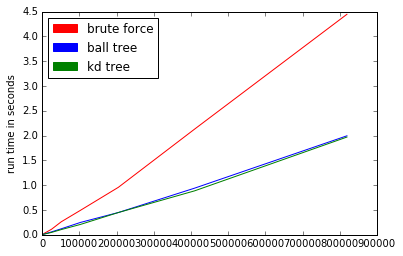

In [8]:
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sample_size = 200
brute_run_times = []
ball_run_times = []
kd_run_times = []
sample_x = []
c = 0

while (c < 1):
    sample_x.append(sample_size)
    [data, targets] = datasets.make_classification(n_samples=sample_size, n_features=4,
                                                    random_state=20160217)
    
    test = np.arange(0, 100, 1)
    train = np.arange(100, sample_size, 1)

    for algo in ['brute', 'ball_tree', 'kd_tree']:
        a = time.clock()

        foldnum+=1
        [gen_tr_data, gen_te_data, 
         gen_tr_targets, gen_te_targets] = folds_to_split(data, targets, train, test)

        knn = neighbors.KNeighborsClassifier(n_neighbors=5, algorithm = algo)
        knn.fit(gen_te_data.values, gen_te_targets.values.ravel())
        gen_knn_results.loc[foldnum, 'f={:<8}k={:<5}p={:<8}w={:<10}'.format(folds, k, degree, weight)] = knn.score(gen_tr_data.values,
                                                                                                              gen_tr_targets.values.ravel())
        b = time.clock()
        c = (b - a)
        time_ran = "%.5f" % c
        print "Size: " + str(sample_size) + " algorithm: " + algo + " running time: " + str(time_ran)
        if (algo == 'brute'):
            brute_run_times.append(time_ran)
        elif (algo =='ball_tree'):
            ball_run_times.append(time_ran)
        else:
            kd_run_times.append(time_ran)
    sample_size = sample_size * 2
    
# print sample_x
# print brute_run_times
# print ball_run_times
# print kd_run_times

plt.plot(sample_x, brute_run_times, "r", sample_x, ball_run_times, 'b', sample_x, kd_run_times, 'g')
red_patch = mpatches.Patch(color='red', label='brute force')
blue_patch = mpatches.Patch(color='blue', label='ball tree')
green_patch = mpatches.Patch(color='green', label='kd tree')

plt.legend(handles=[red_patch, blue_patch, green_patch], loc='upper left')

plt.ylabel("run time in seconds")
plt.show()



In [9]:
print sample_x

[200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 204800, 409600, 819200]


Size: 10 algorithm: ball_tree running time: 2.62227
Size: 10 algorithm: kd_tree running time: 2.92251
Size: 20 algorithm: ball_tree running time: 3.73325
Size: 20 algorithm: kd_tree running time: 3.75784
Size: 40 algorithm: ball_tree running time: 4.84724
Size: 40 algorithm: kd_tree running time: 5.99769
Size: 80 algorithm: ball_tree running time: 8.89866
Size: 80 algorithm: kd_tree running time: 11.33307
Size: 160 algorithm: ball_tree running time: 16.27572
Size: 160 algorithm: kd_tree running time: 20.74353
Size: 320 algorithm: ball_tree running time: 33.72186
Size: 320 algorithm: kd_tree running time: 44.91873


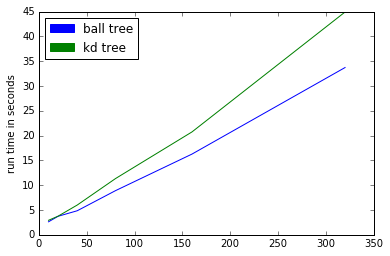

In [10]:
ball_run_times = []
kd_run_times = []
sample_x = []

#10 to 1280
sample_size = 819200
feature_count = 10
while feature_count <= 320:
    sample_x.append(feature_count)
    [data, targets] = datasets.make_classification(n_samples=sample_size, n_features=feature_count,
                                                    random_state=20160217)
    test = np.arange(0, 100, 1)
    train = np.arange(100, sample_size, 1)

    for algo in ['ball_tree', 'kd_tree']:
        a = time.clock()

        foldnum+=1
        [gen_tr_data, gen_te_data, 
         gen_tr_targets, gen_te_targets] = folds_to_split(data, targets, train, test)

        knn = neighbors.KNeighborsClassifier(n_neighbors=5, algorithm = algo)
        knn.fit(gen_te_data.values, gen_te_targets.values.ravel())
        gen_knn_results.loc[foldnum, 'f={:<8}k={:<5}p={:<8}w={:<10}'.format(folds, k, degree, weight)] = knn.score(gen_tr_data.values,
                                                                                                              gen_tr_targets.values.ravel())
        b = time.clock()
        c = (b - a)
        time_ran = "%.5f" % c
        print "Size: " + str(feature_count) + " algorithm: " + algo + " running time: " + str(time_ran)
        if (algo =='ball_tree'):
            ball_run_times.append(time_ran)
        else:
            kd_run_times.append(time_ran)
    
    feature_count = feature_count * 2
    
# print sample_x
# print ball_run_times
# print kd_run_times

plt.plot(sample_x, ball_run_times, 'b', sample_x, kd_run_times, 'g')
blue_patch = mpatches.Patch(color='blue', label='ball tree')
green_patch = mpatches.Patch(color='green', label='kd tree')

plt.legend(handles=[blue_patch, green_patch], loc='upper left')

plt.ylabel("run time in seconds")
plt.show()

